In [59]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, seaborn as sns, sympy
from scipy import stats
from astroquery.vizier import Vizier
from astropy.table import Table as ap_table
from tools import hms_to_dec, dms_to_dec

pd.set_option('display.max_columns', None)

v = Vizier()
v.ROW_LIMIT = -1 # no row limit

In [68]:
files = ["./catalogs/BeSS_"+name+".csv" for name in ["catalog","Chandra_1as","Gaia_1as","GaiaDist_1as","HMXBs_1as","Simbad_1as","Swift_1as","XMM_2as"]]
xmatches = [pd.read_csv(filename) for filename in files]

for df in xmatches:
    for i in range(1,2265):
        instances = len(df[df["#"]==i])
        if instances == 0:
            pass
        elif instances >= 2:
            dupeframe = df[df["#"]==i][["#","angDist"]]
            df.drop(dupeframe[dupeframe["angDist"]>min(dupeframe["angDist"])].index, inplace=True)
    if "angDist" in df.columns:
        df.drop(["angDist"],axis=1,inplace=True)

master = xmatches[0]
for df in xmatches[1:]:
    master = pd.merge(master,df,on=list(xmatches[0].columns),how="left")
master = pd.merge(master,pd.read_csv("./catalogs/Gaia_epsi_Be.csv"), on="#", how="left")
master.drop([733,805,894,1419,1422,1461],axis=0,inplace=True)

In [70]:
for i in master.index:
    if master.loc[i,"main_type"] in ["Ae*","Be*","Em*","Candidate_Be*"]:
        master.loc[i,"Class"] = "Em"
    elif master.loc[i,"main_type"] in ["*","Star","IR","SG*","PM*","Candidate_RGB*","BlueSG*"]:
        master.loc[i,"Class"] = "Star"
    elif master.loc[i,"main_type"] in ["EB*",'EB*Algol','EB*WUMa','EB*betLyr',"SB*","**","multiple_object"]:
        master.loc[i,"Class"] = "Binary"
    elif master.loc[i,"main_type"] in ["Pe*","WR*","Pec*"]:
        master.loc[i,"Class"] = "Peculiar/WR"
    elif master.loc[i,"main_type"] in ["Y*?", "Y*O","Candidate_YSO","YSO"]:
        master.loc[i,"Class"] = "YSO"
    elif master.loc[i,"main_type"] in ["post-AGB*","*inNeb","HII","Cloud"]:
        master.loc[i,"Class"] = "Nebular"
    elif master.loc[i,"main_type"] in ["Eruptive*","Orion_V*","V*","PulsV*bCep","PulsV*","RotV*alf2CVn"]:
        master.loc[i,"Class"] = "Variable"
    elif master.loc[i,"main_type"] in ["HXB","HMXB"]:
        master.loc[i,"Class"] = "HMXB"
    elif pd.isna(master.loc[i,"main_type"]):
        master.loc[i,"Class"] = "Unknown"
    else:
        master.loc[i,"Class"] = "Other"

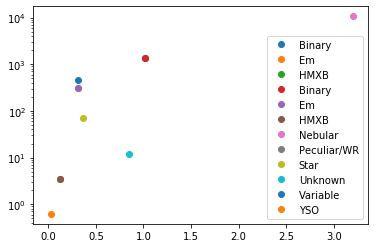

In [119]:
for key,frame in master.groupby("Class"):
    plt.plot(np.mean(frame["epsi"].dropna()),np.mean(frame["sepsi"].dropna()),"o",label=key)
plt.yscale("log")
plt.legend()
plt.show()

C:\Users\Caden Gobat\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Caden Gobat\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Caden Gobat\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Caden Gobat\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


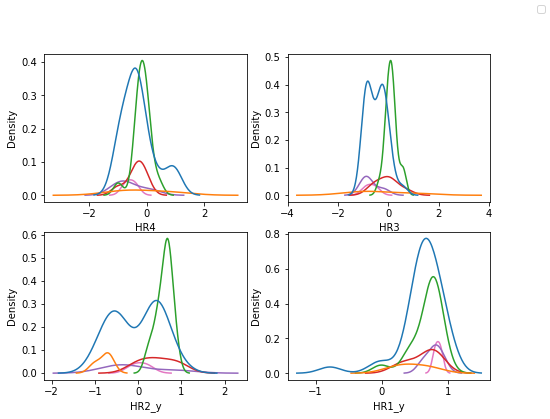

In [211]:
fig,axs = plt.subplots(figsize=(8,6), ncols=2,nrows=2)

sns.kdeplot(data=master[master["Class"]!="Star"], x="HR4", hue="Class", ax=axs[0,0], legend=False)
sns.kdeplot(data=master[master["Class"]!="Star"], x="HR3", hue="Class", ax=axs[0,1], legend=False)
sns.kdeplot(data=master[master["Class"]!="Star"], x="HR2_y", hue="Class", ax=axs[1,0], legend=False)
sns.kdeplot(data=master[master["Class"]!="Star"], x="HR1_y", hue="Class", ax=axs[1,1], legend=False)
fig.legend()
plt.show()
#stats.ks_2samp(master[master["Class"]=="Star"]["epsi"], master[master["Class"]=="Em"]["epsi"])

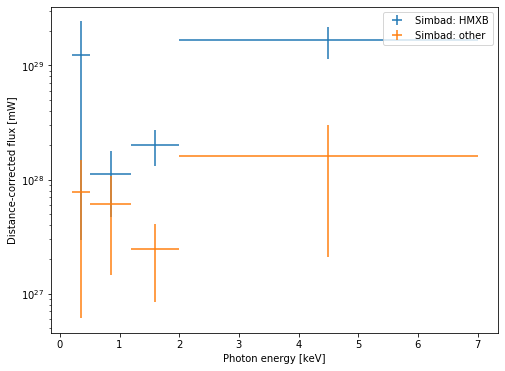

In [162]:
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

HMXBs_CXO = master[(master["Class"]=="HMXB") & (~master["Fluxb"].isna())]
other_CXO = master[(master["Class"]!="HMXB") & (~master["Fluxb"].isna())]

for band in "usmh":
    HMXBs_CXO.loc[:,"Lum"+band] = 4*np.pi*HMXBs_CXO.loc[:,"Flux"+band]*(HMXBs_CXO.loc[:,"rest"]*30856780000000000)**2
    other_CXO.loc[:,"Lum"+band] = 4*np.pi*other_CXO.loc[:,"Flux"+band]*(other_CXO.loc[:,"rest"]*30856780000000000)**2

fig = plt.figure(figsize=(8,6))
plt.errorbar([np.mean(chandra_bands[band]) for band in "usmh"],[np.mean(HMXBs_CXO["Lum"+band]) for band in "usmh"],
             xerr=[(chandra_bands[band][1]-chandra_bands[band][0])/2 for band in "usmh"],
             yerr=[stats.sem(HMXBs_CXO["Lum"+band].dropna()) for band in "usmh"],linestyle="",label="Simbad: HMXB")
plt.errorbar([np.mean(chandra_bands[band]) for band in "usmh"],[np.mean(other_CXO["Lum"+band]) for band in "usmh"],
             xerr=[(chandra_bands[band][1]-chandra_bands[band][0])/2 for band in "usmh"],
             yerr=[stats.sem(other_CXO["Lum"+band].dropna()) for band in "usmh"],linestyle="",label="Simbad: other")
plt.yscale("log")
plt.ylabel("Distance-corrected flux [mW]")
plt.xlabel("Photon energy [keV]")
plt.legend()
plt.show()

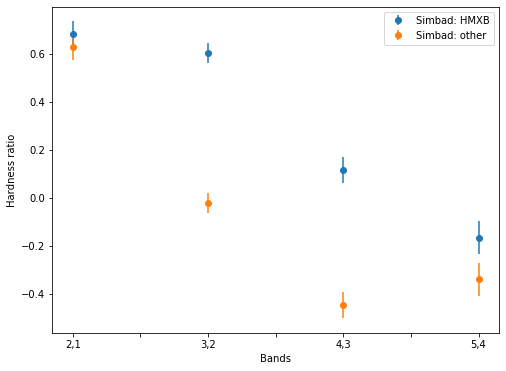

In [187]:
xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))

HMXBs_XMM = master[(master["Class"]=="HMXB") & (~master["Flux8"].isna())]
other_XMM = master[(master["Class"]!="HMXB") & (~master["Flux8"].isna())]

fig,ax = plt.subplots(figsize=(8,6))
ax.errorbar([1,2,3,4],
             [np.mean(HMXBs_XMM["HR"+band]) for band in ["1_y","2_y","3","4"]],
             yerr=[stats.sem(HMXBs_XMM["HR"+band].dropna()) for band in ["1_y","2_y","3","4"]],
             linestyle="",marker="o",label="Simbad: HMXB")
ax.errorbar([1,2,3,4],
             [np.mean(other_XMM["HR"+band]) for band in ["1_y","2_y","3","4"]],
             yerr=[stats.sem(HMXBs_XMM["HR"+band].dropna()) for band in ["1_y","2_y","3","4"]],
             linestyle="",marker="o",label="Simbad: other")
ax.set_xlabel("Bands")
ax.set_ylabel("Hardness ratio")
ax.set_xticklabels([None,"2,1",None,"3,2",None,"4,3",None,"5,4"])
ax.legend()
plt.show()

In [290]:
master.to_csv("./catalogs/master.csv",index=False)

In [190]:
for band in "usmh":
    master.loc[:,"Lum"+band] = 4*np.pi*master.loc[:,"Flux"+band]*(master.loc[:,"rest"]*30856780000000000)**2

master[(master["Lumh"]>1e29) | (master["HR2_y"]>0.5)]

,#,Be star,Category,RA,DEC,V,Type,vsini,Nb of spectra in BeSS,_RAJ2000_CXO,_DEJ2000_CXO,2CXO,Fluxb,Fluxh,Fluxm,Fluxs,Fluxu,Fluxw,S/N,NHGal,HRhm,HRhs,HRms,_RAJ2000_Gaia,_DEJ2000_Gaia,source_id,parallax,pmra_x,pmdec_x,Gflux,Gmag,BPflux,BPmag,RPflux,RPmag,radial_velocity,teff_val,a_g_val,radius_val,lum_val,gaia_id,_RAJ2000_gaia2dis,_DEJ2000_gaia2dis,rest,_RAJ2000_HMXB,_DEJ2000_HMXB,HMXB_Name,Type.1,Vmag,Porb,SpType,main_id,_RAJ2000_Simbad,_DEJ2000_Simbad,main_type,other_types,radvel,redshift,sp_type,plx,pmra_y,pmdec_y,B,V.1,R,J,H,K,u,g,r,i,z,_RAJ2000_XRT,_DEJ2000_XRT,2SXPS,CR0,HR1_x,HR2_x,PcstS0,FPO0,FPU0,_RAJ2000_XMM,_DEJ2000_XMM,Source,4XMM,Flux8,HR1_y,HR2_y,HR3,HR4,VarFlag,epsi,sepsi,Class,Lumu,Lums,Lumm,Lumh
51,52,RX J0049.7-7323,Classical,00 49 41.99,-73 23 14.71,14.980,B2Ve,NaN,0,12.425003,-73.387415,J004942.0-732314,3.639864e-14,2.823236e-14,6.315251e-15,1.991827e-15,0.000000e+00,NaN,58.367,4.58,0.30106,0.54841,0.29482,12.425031,-73.387410,4.685927e+18,-0.0403,0.623,-1.152,22148.3,14.825013,1.631400e+04,14.819985,11308.50,14.628409,NaN,9281.25,NaN,NaN,NaN,4.685927e+18,12.425040,-73.387415,10961.523170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIN 139,12.425031,-73.387410,HMXB,Em*|HXB|IR |X |* |Psr|Be?|Psr|HXB|Em*|HXB,NaN,NaN,O9.5-B0.5III-V,NaN,0.62,-1.15,15.000,14.980,NaN,14.551,14.482,14.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.426001,-73.387425,2.011000e+14,J004942.2-732314,7.610000e-13,0.781369,0.672771,0.141023,-0.024442,0.0,0.074,0.853,HMXB,0.000000e+00,2.863548e+27,9.079115e+27,4.058823e+28
59,60,DZ Tuc,Classical,00 50 44.69,-73 16 05.16,15.440,Be,NaN,0,12.686215,-73.268134,J005044.6-731605,4.052841e-13,3.564553e-13,3.766034e-14,1.595900e-14,2.641786e-14,NaN,66.336,4.83,0.52467,0.64085,0.17489,12.686282,-73.268176,4.685929e+18,-0.0418,0.755,-1.126,13573.7,15.356619,1.056320e+04,15.291896,6298.32,15.263858,NaN,9572.50,NaN,NaN,NaN,4.685929e+18,12.686293,-73.268181,9042.696195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V* DZ Tuc,12.686282,-73.268176,HMXB,IR |V* |HXB|X |Em*|Psr|* |Psr|HXB|Em*|HXB,NaN,NaN,B0-B0.5V,NaN,0.76,-1.13,15.370,15.440,NaN,15.296,15.160,15.010,NaN,NaN,NaN,NaN,NaN,12.68685,-73.26817,24913.0,0.0180,0.594,0.461,4.710000e-02,1.507000e-12,1.640000e-12,12.686311,-73.268182,2.011000e+14,J005044.7-731605,9.690000e-13,0.850844,0.628668,0.120864,-0.073112,0.0,0.119,1.610,HMXB,2.584667e+28,1.561395e+28,3.684607e+28,3.487483e+29
65,66,SMC 25,Classical,00 51 52.01,-73 10 33.96,14.450,Be,NaN,0,12.966979,-73.176218,J005152.0-731034,5.698938e-13,4.396309e-13,6.843061e-14,7.165196e-14,1.033156e-12,NaN,50.777,5.03,0.35228,0.19613,-0.16740,12.966770,-73.176151,4.685938e+18,-0.1357,0.725,-1.064,34254.7,14.351566,2.655240e+04,14.291129,15363.40,14.295699,NaN,9522.75,NaN,NaN,NaN,4.685938e+18,12.966780,-73.176155,12460.374970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIN 193,12.966770,-73.176151,HMXB,Em*|HXB|X |* |IR |SNR|Psr|Be*|Be?|Psr|HXB|Em...,NaN,NaN,O9.5-B0V,NaN,0.73,-1.06,14.380,14.450,14.24,14.430,14.760,14.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.966676,-73.176081,2.011000e+14,J005152.0-731033,1.890000e-12,0.664199,0.297753,-0.034882,-0.193246,1.0,0.207,8.320,HMXB,1.919284e+30,1.331071e+29,1.271229e+29,8.166980e+29
81,82,CXOU J005323.8-722715,Classical,00 53 23.90,-72 27 15.12,16.190,Be,NaN,0,13.349516,-72.454314,J005323.8-722715,2.417283e-13,2.068998e-13,2.401566e-14,1.174050e-14,3.870456e-15,NaN,33.424,6.98,0.48220,0.58963,0.14741,13.349412,-72.454291,4.689005e+18,-0.0110,0.679,-1.264,6193.1,16.208595,5.186340e+03,16.064236,2515.10,16.260530,NaN,8565.00,NaN,NaN,NaN,4.689005e+18,13.349421,-72.454296,6692.143440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RX J0053.4-7227,13.349412,-72.454291,HMXB,IR |HXB|X |Em*|Psr|* |HXB|Em*|HXB,NaN,NaN,B1-B2IV-V,NaN,0.68,-1.26,16.110,16.190,NaN,16.260,15.802,16.310,NaN,NaN,NaN,NaN,NaN,13.34877,-72.45433,4024.0,0.0115,0.622,0.346,4.940000e-11,8.708000e-13,9.620000e-13,13.349272,-72.454332,2.050098e+14,J005323.8-722715,7.250000e-13,0.732062,0.523565,0.084874,-0.236643,1.0,0.195,2.450,HMXB,2.07

In [200]:
F1 = sympy.var("F_1")
F2 = sympy.var("F_2")
F3 = sympy.var("F_3")
F4 = sympy.var("F_4")
F5 = sympy.var("F_5")
F8 = 1
HR1 = 0.6
HR2 = 0.4
HR3 = 0
HR4 = -0.15
system = [F1+F2+F3+F4+F5-F8,
         (F2-F1)/(F2+F1)-HR1,
         (F3-F2)/(F3+F2)-HR2,
         (F4-F3)/(F4+F3)-HR3,
         (F5-F4)/(F5+F4)-HR4]
vars_ = [F1,F2,F3,F4,F5]
sympy.nonlinsolve(system, vars_)

FiniteSet((0.0327169274537695, 0.130867709815078, 0.305357989568516, 0.305357989568516, 0.22569938359412))